[*********************100%***********************]  1 of 1 completed

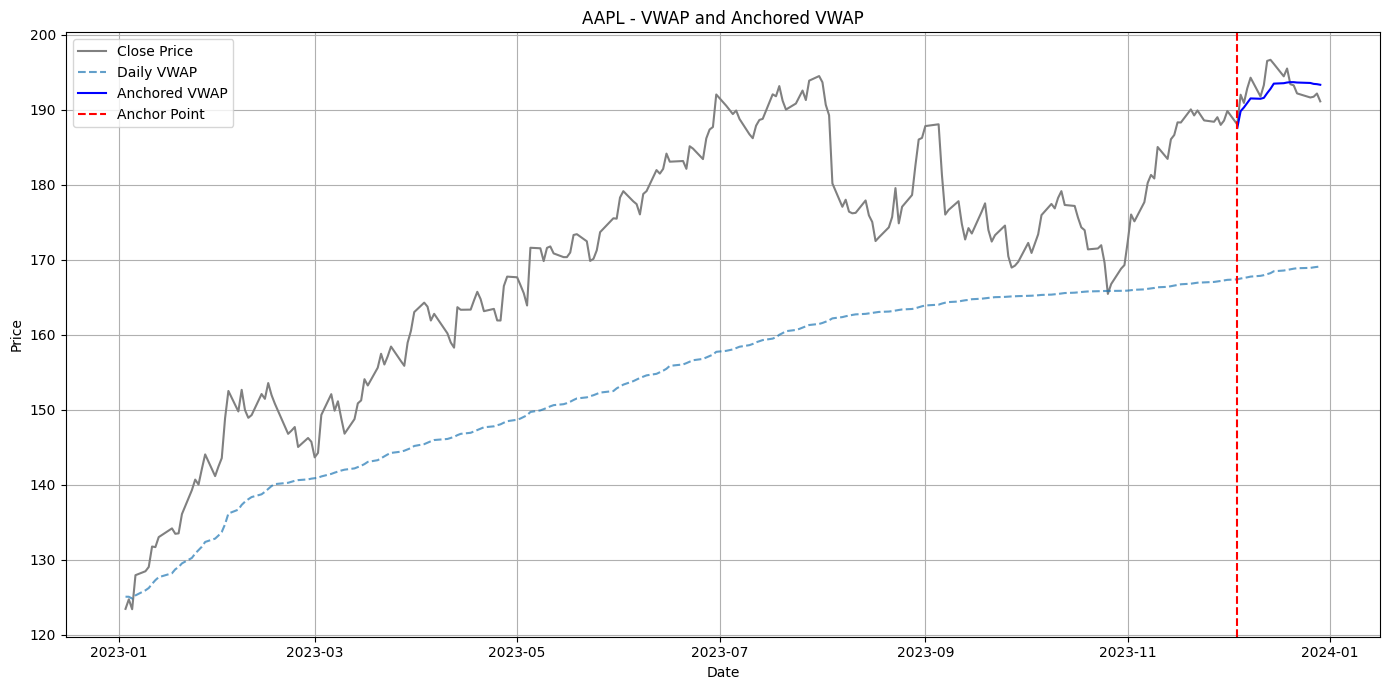

In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Download data (this will have MultiIndex with level 0 as 'Price' and level 1 as ticker)
ticker = "AAPL"
start_date = "2023-01-01"
end_date = "2024-01-01"
data = yf.download(ticker, start=start_date, end=end_date, group_by='ticker')

# Fix: Flatten by extracting AAPL across the second level of the MultiIndex
data = data.xs(ticker, level='Ticker', axis=1)

# Calculate VWAP
data['Typical_Price'] = (data['High'] + data['Low'] + data['Close']) / 3
data['TPV'] = data['Typical_Price'] * data['Volume']
data['Cum_TPV'] = data['TPV'].cumsum()
data['Cum_Volume'] = data['Volume'].cumsum()
data['VWAP'] = data['Cum_TPV'] / data['Cum_Volume']

# Fix: Use last 30-day swing low (lowest low) and anchor from that date forward
rolling_window = 30
recent_lows = data['Low'].iloc[-rolling_window:]  # get the last 30 rows of 'Low'
anchor_date_idx = recent_lows.idxmin()            # get the date of the swing low

# Calculate Anchored VWAP from swing low
anchored_data = data.loc[anchor_date_idx:].copy()
anchored_data['AVWAP'] = anchored_data['TPV'].cumsum() / anchored_data['Volume'].cumsum()

# Merge AVWAP into main dataframe
data.loc[anchor_date_idx:, 'AVWAP'] = anchored_data['AVWAP']

# Plot VWAP and Anchored VWAP
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price', color='gray')
plt.plot(data.index, data['VWAP'], label='Daily VWAP', linestyle='--', alpha=0.7)
plt.plot(data.index, data['AVWAP'], label='Anchored VWAP', color='blue')
plt.axvline(anchor_date_idx, color='red', linestyle='--', label='Anchor Point')
plt.title(f"{ticker} - VWAP and Anchored VWAP")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
